# Intuition

We can have 2 kinds of predictions:

1. Given that the customer has not bought before, 
    1. Can we use their demographics to determine:
        1. How much (dollar amount) they will buy?
        2. How many items they will buy?
        3. What categories they will buy?
2. Given that the customer has made a purchase, 
    1. Can we see if their demographics, purchase history and purchase experience determine the likelihood of them returning?
        1. Compare the non-last transactions of repeat customers against transactions by single-time customers
    2. Can we compare past purchases to future ones? 
        1. E.g. to see if big spenders always spend big for all purchases. 
          Or those that buy from a certain category will continue to buy from that category. 
    3. Can we segment customers based on their purchase history? 
        1. Can also explore if particular segments have higher chance of returning customers. 
    
Can we segment customers based on what they purchase? E.g.:
* Those that purchase huge range of products
* Those that purchase only 1 item

# Import Data

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from IPython.display import Markdown, display
from pandas_profiling import ProfileReport
from sklearn.metrics import precision_score, recall_score
from tabulate import tabulate
from tqdm import tqdm_notebook

sns.set(rc={'figure.figsize':(14, 6)})

tqdm_notebook().pandas()

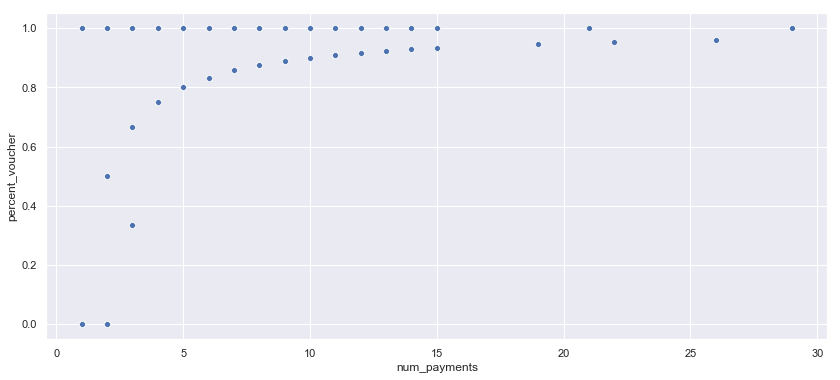

In [34]:
sns.scatterplot(order_payments.num_payments, order_payments.percent_voucher)

In [121]:
customers = pd.read_csv("data/olist_customers_dataset.csv")
orders = pd.read_csv("data/olist_orders_dataset.csv")
order_items = pd.read_csv("data/olist_order_items_dataset.csv")
reviews = pd.read_csv("data/olist_order_reviews_dataset.csv")
products = pd.read_csv("data/olist_products_dataset.csv").set_index('product_id')
products.product_category_name.fillna('others', inplace=True)
order_items = order_items.join(products, on='product_id').drop(['order_item_id'], axis=1)

order_payments = pd.read_csv("data/olist_order_payments_dataset.csv")
order_payments = order_payments.groupby('order_id').agg({'payment_type': ['size', 'nunique', lambda x: (x == 'voucher').sum() / x.shape[0]], 'payment_installments': ['sum']})
order_payments.columns = ['num_payments', 'nunique_payments', 'percent_voucher', 'num_installments']

for col in ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']:
    orders[col] = pd.to_datetime(orders[col])
    
state_data = pd.read_csv("data/brazil_state_data.csv")
state_data.set_index('state', inplace=True)
state_data['gdp_per_capita'] = state_data['gdp'] / state_data['population']
state_data['population_density'] = state_data['population'] / state_data['size']
customers = customers.join(state_data, on='customer_state')

orders = orders.merge(customers, on='customer_id').drop('customer_id', axis=1).join(order_payments, on='order_id')

In [109]:
reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'])

* GDP Data: https://agenciadenoticias.ibge.gov.br/en/agencia-press-room/2185-news-agency/releases-en/10155-gdp-of-municipalities-agriculture-represents-more-than-half-of-economic-activity-in-1-135-municipalities
* Population Data: https://en.wikipedia.org/wiki/List_of_Brazilian_federative_units_by_gross_regional_product 
* Size Data: http://www.brazil-help.com/brazilian_states.htm

# Data Preparation

## Joining and preparing data columns

In [122]:
orders['time_to_approve'] = (orders.order_approved_at - orders.order_purchase_timestamp).dt.total_seconds()
orders['time_to_ship'] = (orders.order_delivered_carrier_date - orders.order_approved_at).dt.total_seconds()
orders['time_to_reach'] = (orders.order_delivered_customer_date - orders.order_delivered_carrier_date).dt.total_seconds()
orders['days_delivery_diff'] = (orders.order_estimated_delivery_date - orders.order_delivered_customer_date).dt.days
orders['month_purchase'] = orders.order_purchase_timestamp.dt.month

In [123]:
orders['customer_num_order'] = orders.groupby('customer_unique_id')['order_purchase_timestamp'].rank()

In [124]:
max_num_orders = pd.DataFrame(customers.customer_unique_id.value_counts())
max_num_orders.columns = ['max_num_orders']

In [125]:
order_details = order_items.groupby('order_id').agg({'price': ['size', 'sum', 'mean'], 'freight_value': ['sum', 'mean'], 'product_id': ['nunique'], 'seller_id': ['nunique']})
cols = ['_'.join(col) for col in order_details.columns]
cols[0] = 'num_items'
order_details.columns = cols

In [126]:
order_reviews = reviews.groupby('order_id').agg({'review_score': ['size', 'mean']})
order_reviews.columns = ['num_reviews', 'avg_review']

In [127]:
orders.shape

(99441, 26)

In [128]:
orders = orders.join(order_reviews, on='order_id').fillna(0)

In [133]:
orders.shape

(99441, 36)

In [132]:
orders = orders.join(max_num_orders, on='customer_unique_id').join(order_details, on='order_id')

## Converting Categories

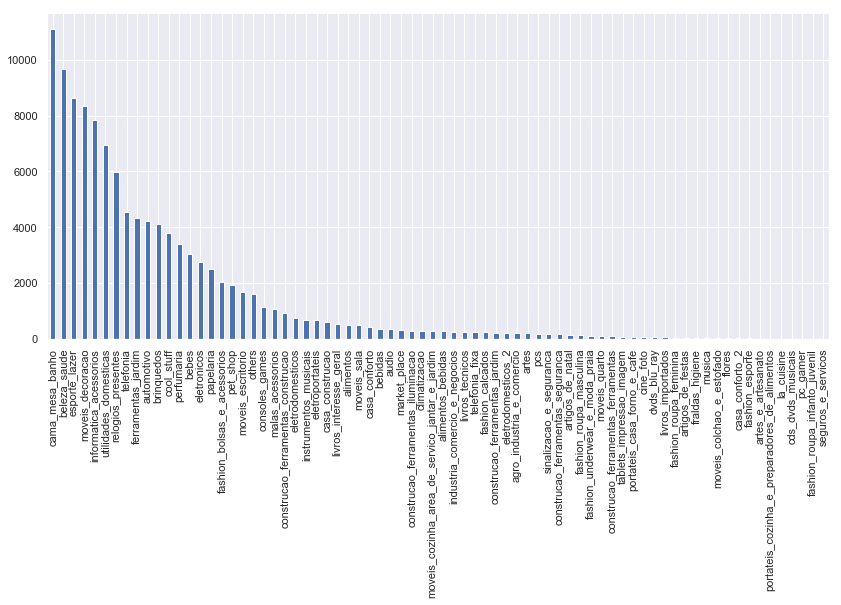

In [15]:
order_items.product_category_name.value_counts().plot(kind='bar')

In [11]:
first_n = 25
percent = order_items.product_category_name.value_counts()[:first_n].sum() / order_items.shape[0] * 100
display(Markdown("The first {} categories account for {:.2f}% of all orders. Let's convert the rest to \"others\".".format(first_n, percent)))

The first 25 categories account for 91.64% of all orders. Let's convert the rest to "others".

In [12]:
categories = pd.DataFrame(order_items.product_category_name.value_counts())
categories['product_category_name'] = categories.index
categories[first_n:]['product_category_name'] = 'others'

C:\Users\leeye\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
if 'product_category' in order_items.columns:
    order_items.drop('product_category', axis=1, inplace=True)
categories.columns = ['product_category']
order_items = order_items.join(categories, on='product_category_name')

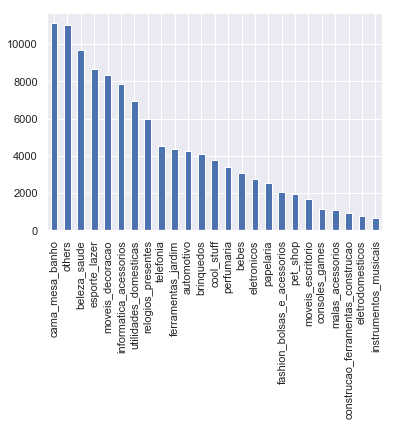

In [14]:
order_items.product_category.value_counts().plot(kind='bar')

# Some EDA

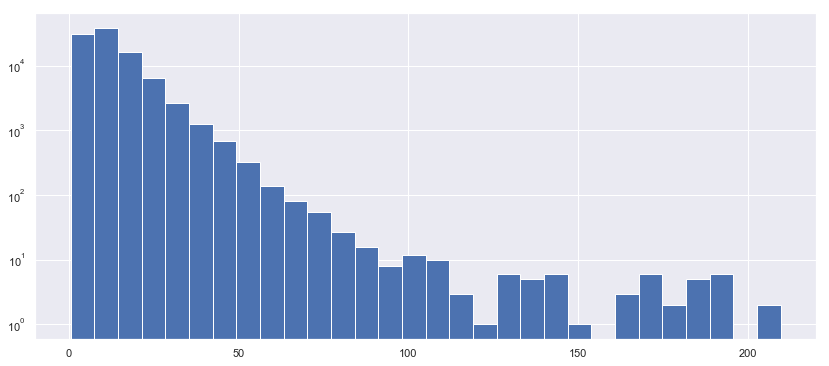

In [105]:
((orders.time_to_approve + orders.time_to_ship + orders.time_to_reach) / 86400).hist(bins = 30)
plt.yscale('log')

In [23]:
orders[['order_purchase_timestamp']].set_index('order_purchase_timestamp').resample('W').size().sort_values(ascending=False)

order_purchase_timestamp
2017-11-26    3008
2017-12-03    2098
2018-08-05    2058
2018-08-12    1988
2018-05-13    1987
2018-03-04    1903
2018-08-19    1875
2018-05-20    1837
2018-01-14    1785
2018-05-06    1770
2018-02-25    1756
2018-01-21    1750
2018-03-25    1716
2017-12-10    1692
2018-07-22    1678
2018-04-29    1676
2018-04-22    1672
2018-07-29    1646
2018-03-11    1643
2018-02-18    1640
2018-02-04    1598
2018-03-18    1595
2018-01-28    1591
2018-04-08    1590
2018-02-11    1584
2018-04-15    1554
2018-06-17    1514
2018-04-01    1471
2018-06-24    1457
2018-06-10    1438
              ... 
2017-01-29     354
2016-10-09     283
2017-01-22     197
2018-09-02     130
2017-01-15      80
2017-01-08      46
2016-10-16      39
2018-09-09       7
2018-09-16       4
2018-09-30       3
2016-09-18       2
2018-10-21       2
2018-10-07       2
2018-09-23       2
2016-09-04       1
2016-12-25       1
2016-09-11       1
2016-10-02       1
2016-10-23       1
2016-09-25       0
2018-1

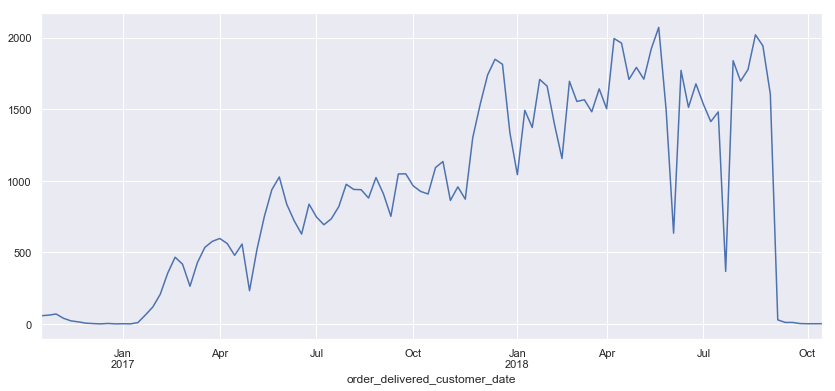

In [628]:
orders[['order_delivered_customer_date']].set_index('order_delivered_customer_date').resample('W').size().plot()

## Analysing Sellers vs Products

In [42]:
repeats = (customers.customer_unique_id.value_counts().value_counts(normalize=True).sort_index() * 100)
repeats[3:].sum()

0.05099067599067599

In [377]:
tmp = order_items.join(orders.set_index('order_id'), on='order_id')

In [389]:
tmp[['seller_id', 'product_id']].drop_duplicates().groupby('product_id').size().sort_values(ascending=False).head()

product_id
d285360f29ac7fd97640bf0baef03de0    8
69455f41626a745aea9ee9164cb9eafd    8
4298b7e67dc399c200662b569563a2b2    7
36f60d45225e60c7da4558b070ce4b60    7
656e0eca68dcecf6a31b8ececfabe3e8    7
dtype: int64

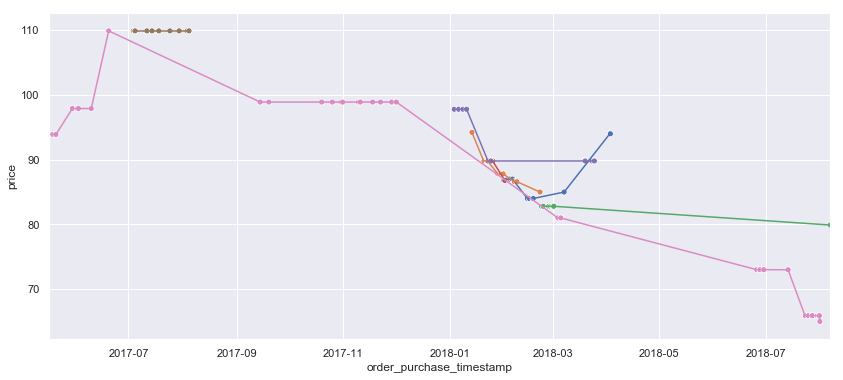

In [396]:
t = tmp[['order_purchase_timestamp', 'seller_id', 'product_id', 'price']].drop_duplicates()
t = t[t.product_id == '656e0eca68dcecf6a31b8ececfabe3e8'].sort_values(['seller_id', 'order_purchase_timestamp'])
sns.lineplot(t.order_purchase_timestamp, t.price, hue=t.seller_id)
sns.scatterplot(t.order_purchase_timestamp, t.price, hue=t.seller_id)
plt.xlim(t.order_purchase_timestamp.min(), t.order_purchase_timestamp.max())
plt.legend().remove()

# Analysis

In [13]:
from sklearn.metrics import mean_squared_error

## Analysing All Customers

### Using Demographics to Predict Purchase Volume

In [16]:
orders.columns

Index(['order_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'gdp', 'size', 'population', 'gdp_per_capita',
       'population_density', 'num_payments', 'nunique_payments',
       'percent_voucher', 'num_installments', 'time_to_approve',
       'time_to_ship', 'time_to_reach', 'days_delivery_diff', 'month_purchase',
       'customer_num_order', 'max_num_orders', 'num_items', 'price_sum',
       'price_mean', 'freight_value_sum', 'freight_value_mean',
       'product_id_nunique', 'seller_id_nunique', 'num_reviews', 'avg_review'],
      dtype='object')

In [53]:
customers.customer_zip_code_prefix.nunique()

14994

In [45]:
orders[['price_sum', 'num_items', 'customer_state', 'gdp', 'size', 'population', 'customer_city', 'customer_zip_code_prefix']].head()

,price_sum,num_items,customer_state,gdp,size,population,customer_city,customer_zip_code_prefix
0,29.99,1.0,SP,628064882,248209,44035304,sao paulo,3149
1,118.70,1.0,BA,56624041,564692,15126371,barreiras,47813
2,159.90,1.0,GO,46094735,340086,6523222,vianopolis,75265
3,45.00,1.0,RN,19076030,52796,3408510,sao goncalo do amarante,59296
4,19.90,1.0,SP,628064882,248209,44035304,santo andre,9195


In [28]:
orders[['population_density', 'size', 'population']].corr().abs()

,population_density,size,population
population_density,1.000000,0.620802,0.195046
size,0.620802,1.000000,0.003085
population,0.195046,0.003085,1.000000


In [35]:
orders[['num_items', 'seller_id_nunique', 'product_id_nunique']].corr()

,num_items,seller_id_nunique,product_id_nunique
num_items,1.000000,0.282200,0.470977
seller_id_nunique,0.282200,1.000000,0.592784
product_id_nunique,0.470977,0.592784,1.000000


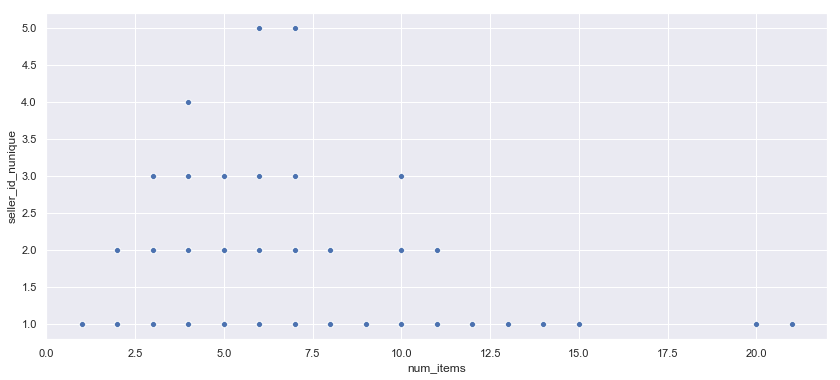

In [34]:
sns.scatterplot(orders.num_items, orders.seller_id_nunique)

In [37]:
orders

,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,...,max_num_orders,num_items,price_sum,price_mean,freight_value_sum,freight_value_mean,product_id_nunique,seller_id_nunique,num_reviews,avg_review
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,...,2,1.0,29.99,29.990,8.72,8.72,1.0,1.0,1,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,...,1,1.0,118.70,118.700,22.76,22.76,1.0,1.0,1,4.0
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,...,1,1.0,159.90,159.900,19.22,19.22,1.0,1.0,1,5.0
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,...,1,1.0,45.00,45.000,27.20,27.20,1.0,1.0,1,5.0
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,...,1,1.0,19.90,19.900,8.72,8.72,1.0,1.0,1,5.0
5,a4591c265e18cb1dcee52889e2d8acc3,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,...,1,1.0,147.90,147.900,27.36,27.36,1.0,1.0,1,4.0
6,136cce7faa42fdb2cefd53fdc79a6098,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,36edbb3fb164b1f16485364b6fb04c73,98900,santa rosa,...,1,1.0,49.90,49.900,16.05,16.05,1.0,1.0,1,2.0
7,6514b8ad8028c9f2cc2374ded245783f,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,932afa1e708222e5821dac9cd5db4cae,26525,nilopolis,...,1,1.0,59.99,59.990,15.17,15.17,1.0,1.0,1,5.0
8,76c6e866289321a7c93b82b54852dc33,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06,39382392765b6dc74812866ee5ee92a7,99655,faxinalzinho,...,1,1.0,19.90,19.900,16.05,16.05,1.0,1.0,1,1.0
9,e69bfb5eb88e0ed6a785585b27e16dbf,delivered,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23,299905e3934e9e181bfb2e164dd4b4f8,18075,sorocaba,...,1,1.0,149.99,149.990,19.77,19.77,1.0,1.0,1,5.0


In [40]:
order_items

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,pet_shop
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,moveis_decoracao
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,perfumaria
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,ferramentas_jardim
5,00048cc3ae777c65dbb7d2a0634bc1ea,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,2017-05-23 03:55:27,21.90,12.69,utilidades_domesticas,36.0,558.0,1.0,450.0,24.0,8.0,15.0,utilidades_domesticas
6,00054e8431b9d7675808bcb819fb4a32,8d4f2bb7e93e6710a28f34fa83ee7d28,7040e82f899a04d1b434b795a43b4617,2017-12-14 12:10:31,19.90,11.85,telefonia,52.0,815.0,1.0,200.0,27.0,5.0,20.0,telefonia
7,000576fe39319847cbb9d288c5617fa6,557d850972a7d6f792fd18ae1400d9b6,5996cddab893a4652a15592fb58ab8db,2018-07-10 12:30:45,810.00,70.75,ferramentas_jardim,39.0,1310.0,3.0,13805.0,35.0,75.0,45.0,ferramentas_jardim
8,0005a1a1728c9d785b8e2b08b904576c,310ae3c140ff94b03219ad0adc3c778f,a416b6a846a11724393025641d4edd5e,2018-03-26 18:31:29,145.95,11.65,beleza_saude,59.0,493.0,1.0,2000.0,30.0,12.0,16.0,beleza_saude
9,0005f50442cb953dcd1d21e1fb923495,4535b0e1091c278dfd193e5a1d63b39f,ba143b05f0110f0dc71ad71b4466ce92,2018-07-06 14:10:56,53.99,11.40,livros_tecnicos,52.0,1192.0,1.0,850.0,29.0,3.0,21.0,others


In [39]:
reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37
6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,NaN,NaN,2017-07-16 00:00:00,2017-07-18 19:30:34
7,7c6400515c67679fbee952a7525281ef,c31a859e34e3adac22f376954e19b39d,5,NaN,NaN,2018-08-14 00:00:00,2018-08-14 21:36:06
8,a3f6f7f6f433de0aefbb97da197c554c,9c214ac970e84273583ab523dfafd09b,5,NaN,NaN,2017-05-17 00:00:00,2017-05-18 12:05:37
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47


In [15]:
x_cols = ['population', 'gdp_per_capita', 'size']
y_cols = ['price_sum']
y_categorical = ['num_items', 'seller_id_nunique', 'avg_review']

In [16]:
transformed = orders[x_cols + y_cols + y_categorical].dropna()

In [17]:
transformed = transformed.transform({'population': np.log, 'gdp_per_capita': np.log, 
                                     'size': np.log, 'price_sum': np.log, 
                                     'num_items': lambda x: x > 1, 'seller_id_nunique': lambda x: x > 1, 
                                     'avg_review': lambda x: x > 3})

population


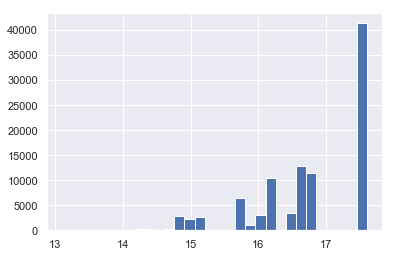

gdp_per_capita


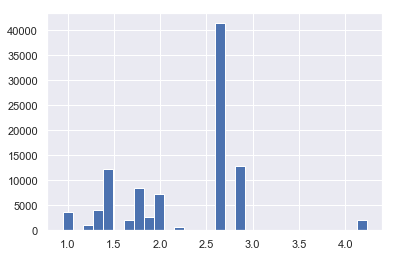

size


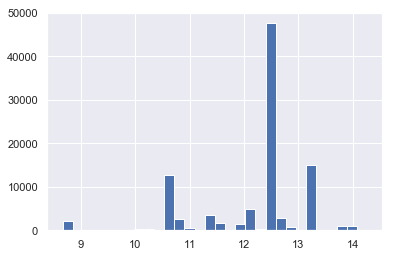

price_sum


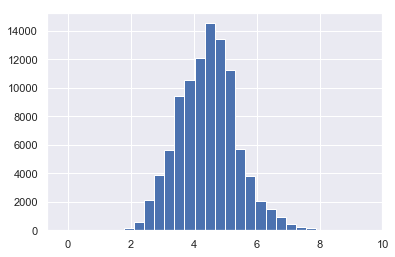

In [18]:
for col in x_cols + y_cols:
    print(col)
    transformed[col].hist(bins=30)
#     plt.yscale('log')
    plt.show()
#     np.log1p(transformed[col]).hist(bins=30)
#     plt.yscale('log')
#     plt.show()
#     np.log1p(np.reciprocal(transformed[col])).hist(bins=30)
#     plt.yscale('log')
#     plt.show()

In [19]:
for y_col in y_cols:
    display(Markdown("# " + y_col))
    subset = transformed[x_cols + [y_col]].dropna() # excluded GDP because high correlation
    X = sm.add_constant(subset.drop(y_col, axis=1))
    y = subset[y_col]

    while True:
        model = sm.OLS(y, X).fit()
        pvals = pd.DataFrame(model.pvalues).drop('const')
        max_pval = pvals.max()[0]
        if max_pval > 0.05:
            to_drop = pvals[pvals[0] == pvals[0].max()].index[0]
            display(Markdown("Dropping `" + to_drop + "` (p-val: `{:.4f}`)".format(max_pval)))
            X.drop(to_drop, inplace=True, axis=1)
        else:
            # no columns with pval > 0.05
            break
    display(model.summary())
#     model, best_score, pred_y = stepwise_regression('ols', subset.drop(y, axis=1), subset[y])
#     display(model.summary())

# price_sum

C:\Users\leeye\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Dropping `size` (p-val: `0.2120`)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_sum   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     259.1
Date:                Wed, 24 Apr 2019   Prob (F-statistic):          6.09e-113
Time:                        16:38:42   Log-Likelihood:            -1.3293e+05
No. Observations:               98666   AIC:                         2.659e+05
Df Residuals:                   98663   BIC:                         2.659e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.6693      0.059     96.377      0.000       5.554       5.785
population        -0.0698      0.004    -18.972      0.000      -0.077      -0.063
gdp_per_capita    -0.0241      0.005     -5.030      0.000      -0.034      -0.015
==============================================================================
Omnibus:                     1267.202   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1414.070
Skew:                           0.240   Prob(JB):                    8.68e-308
Kurtosis:                       3.336   Cond. No.                         338.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
for y_col in y_categorical:
    display(Markdown("# " + y_col))
    subset = transformed[x_cols + [y_col]].dropna() # excluded GDP because high correlation
    X = sm.add_constant(subset.drop(y_col, axis=1))
    y = subset[y_col]

    while True:
        model = sm.Logit(y, X).fit(disp=False)
        pvals = pd.DataFrame(model.pvalues).drop('const')
        max_pval = pvals.max()[0]
        if max_pval > 0.05:
            to_drop = pvals[pvals[0] == pvals[0].max()].index[0]
            display(Markdown("Dropping `" + to_drop + "` (p-val: `{:.4f}`)".format(max_pval)))
            X.drop(to_drop, inplace=True, axis=1)
        else:
            # no columns with pval > 0.05
            break
    display(model.summary())

# num_items

Dropping `size` (p-val: `0.4347`)

Dropping `gdp_per_capita` (p-val: `0.3070`)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              num_items   No. Observations:                98666
Model:                          Logit   Df Residuals:                    98664
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:               0.0001470
Time:                        16:38:44   Log-Likelihood:                -31930.
converged:                       True   LL-Null:                       -31935.
                                        LLR p-value:                  0.002185
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.8444      0.210    -13.540      0.000      -3.256      -2.433
population     0.0381      0.012      3.053      0.002       0.014       0.063
==============================================================================
"""

# seller_id_nunique

Dropping `population` (p-val: `0.4687`)

Dropping `gdp_per_capita` (p-val: `0.0519`)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      seller_id_nunique   No. Observations:                98666
Model:                          Logit   Df Residuals:                    98664
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:               0.0003538
Time:                        16:38:44   Log-Likelihood:                -6822.0
converged:                       True   LL-Null:                       -6824.4
                                        LLR p-value:                   0.02799
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.1221      0.365    -14.019      0.000      -5.838      -4.406
size           0.0647      0.030      2.170      0.030       0.006       0.123
==============================================================================
"""

# avg_review

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             avg_review   No. Observations:                98666
Model:                          Logit   Df Residuals:                    98662
Method:                           MLE   Df Model:                            3
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                0.002173
Time:                        16:38:44   Log-Likelihood:                -52944.
converged:                       True   LL-Null:                       -53059.
                                        LLR p-value:                 1.036e-49
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.9197      0.150     -6.119      0.000      -1.214      -0.625
population         0.0397      0.013      3.041      0.002       0.014       0.065
gdp_per_capita     0.0883      0.018      4.826      0.000       0.052       0.124
size               0.1047      0.013      8.341      0.000       0.080       0.129
==================================================================================
"""

In [57]:
model.tvalues

const                 795.432947
population              1.761143
gdp_per_capita          0.180678
size                    0.836748
population_density     -0.213841
dtype: float64

In [122]:
for y_col in ['price_sum', 'num_items', 'seller_id_nunique']:
    display(Markdown("# " + y_col))
    sub = orders[[y_col, 'gdp_per_capita', 'size']].dropna()
    X2 = sm.add_constant(sub.drop(y_col, axis=1))
    X2['gdp_per_capita'] = np.log1p(X2['gdp_per_capita'])
    X2['size'] = np.log1p(X2['size'])
    est = sm.OLS(np.log1p(sub[y_col]), X2)
    est2 = est.fit()
    display(est2.summary())

# price_sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_sum   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     10.59
Date:                Tue, 23 Apr 2019   Prob (F-statistic):           2.52e-05
Time:                        14:32:09   Log-Likelihood:            -6.6787e+05
No. Observations:               98666   AIC:                         1.336e+06
Df Residuals:                   98663   BIC:                         1.336e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            139.7726      1.701     82.161      0.000     136.438     143.107
gdp_per_capita    -0.2628      0.074     -3.541      0.000      -0.408      -0.117
size            4.259e-06   3.56e-06      1.195      0.232   -2.73e-06    1.12e-05
==============================================================================
Omnibus:                   155664.544   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        293055456.906
Skew:                           9.731   Prob(JB):                         0.00
Kurtosis:                     269.281   Cond. No.                     8.64e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# num_items

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              num_items   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1182
Date:                Tue, 23 Apr 2019   Prob (F-statistic):              0.888
Time:                        14:32:09   Log-Likelihood:                -78921.
No. Observations:               98666   AIC:                         1.578e+05
Df Residuals:                   98663   BIC:                         1.579e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.1408      0.004    262.299      0.000       1.132       1.149
gdp_per_capita  8.298e-05      0.000      0.437      0.662      -0.000       0.000
size           -9.673e-11   9.11e-09     -0.011      0.992    -1.8e-08    1.78e-08
==============================================================================
Omnibus:                   132810.611   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         55156239.033
Skew:                           7.527   Prob(JB):                         0.00
Kurtosis:                     117.847   Cond. No.                     8.64e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# seller_id_nunique

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      seller_id_nunique   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7834
Date:                Tue, 23 Apr 2019   Prob (F-statistic):              0.457
Time:                        14:32:09   Log-Likelihood:                 67327.
No. Observations:               98666   AIC:                        -1.346e+05
Df Residuals:                   98663   BIC:                        -1.346e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.0128      0.001   1025.314      0.000       1.011       1.015
gdp_per_capita   1.21e-05   4.31e-05      0.281      0.779   -7.23e-05    9.65e-05
size            2.537e-09   2.07e-09      1.226      0.220   -1.52e-09    6.59e-09
==============================================================================
Omnibus:                   151974.012   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         61878181.375
Skew:                           9.970   Prob(JB):                         0.00
Kurtosis:                     124.053   Cond. No.                     8.64e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Using Demographics to Predict Purchase Items

In [21]:
subset = orders[['order_id', 'gdp_per_capita', 'gdp', 'population', 'size', 'population_density']].join(order_items.set_index('order_id')[['product_category']], on='order_id', how='right').drop('order_id', axis=1)

In [22]:
subset.groupby('product_category')['gdp_per_capita'].mean()

product_category
automotivo                           11.933927
bebes                                11.937448
beleza_saude                         12.205829
brinquedos                           12.362574
cama_mesa_banho                      12.585952
consoles_games                       12.341583
construcao_ferramentas_construcao    11.830202
cool_stuff                           11.584447
eletrodomesticos                     11.952558
eletronicos                          11.751040
esporte_lazer                        12.274424
fashion_bolsas_e_acessorios          11.715178
ferramentas_jardim                   11.256768
informatica_acessorios               11.845284
instrumentos_musicais                11.199534
malas_acessorios                     11.812197
moveis_decoracao                     11.903564
moveis_escritorio                    11.743079
others                               12.222114
papelaria                            11.994282
perfumaria                           12.467

# gdp_per_capita

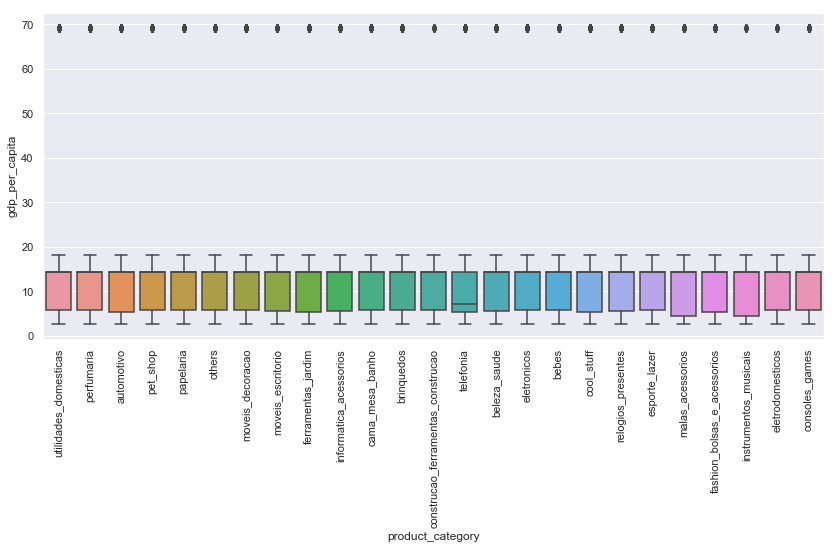

# gdp

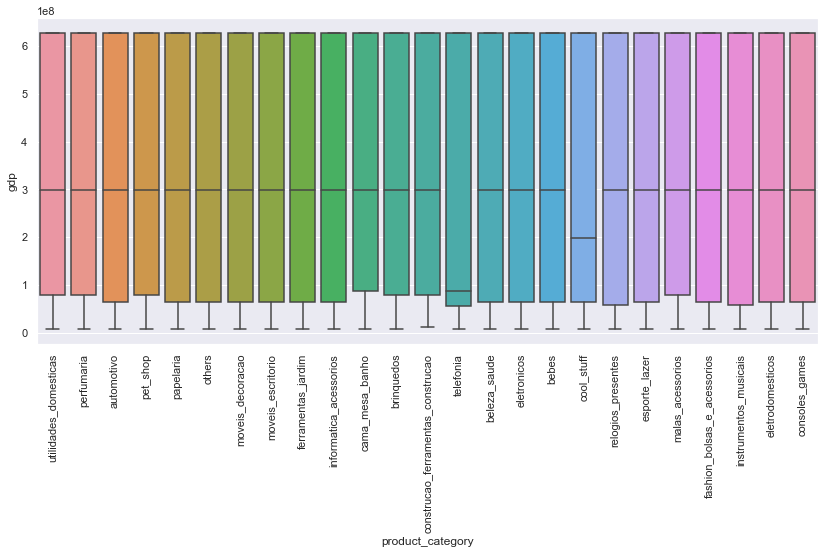

# population

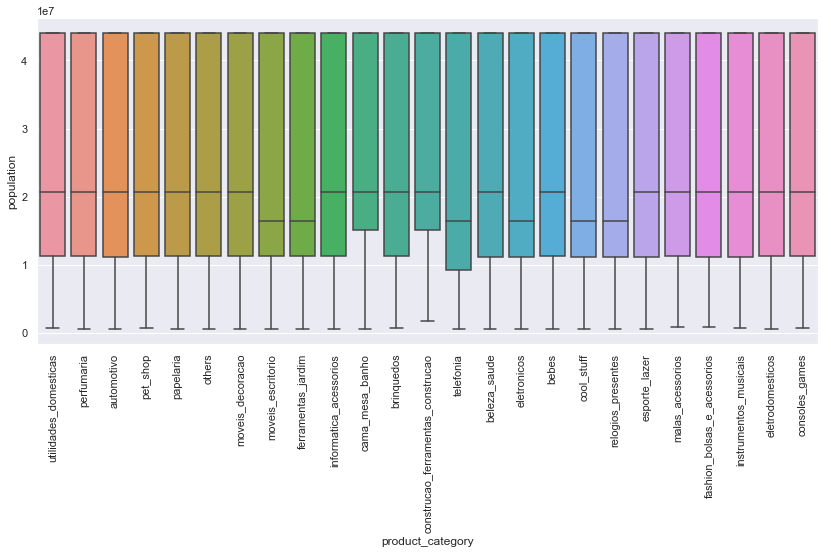

# size

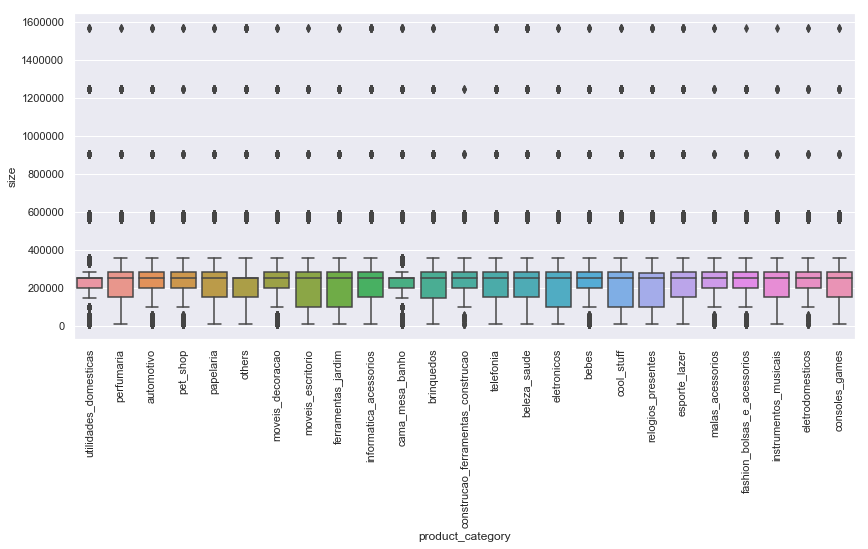

# population_density

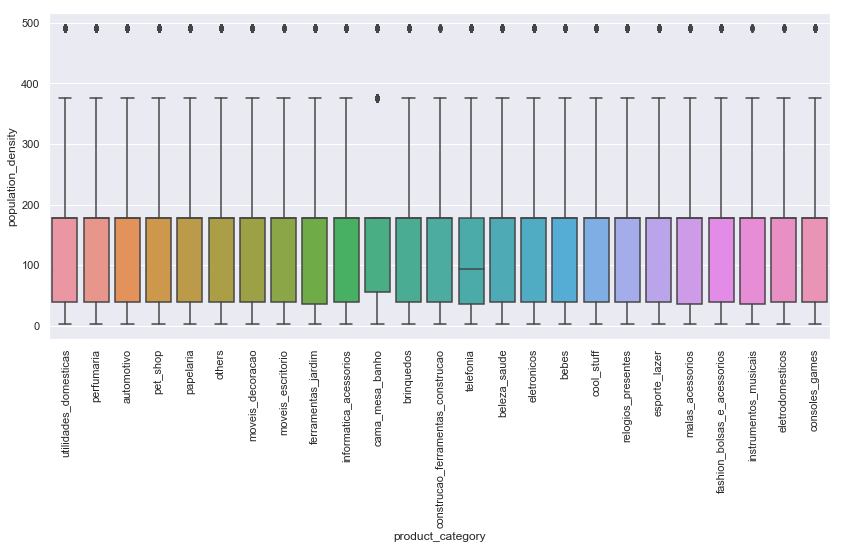

In [111]:
for col in ['gdp_per_capita', 'gdp', 'population', 'size', 'population_density']:
    display(Markdown("# " + col))
    sns.boxplot(subset.product_category, subset[col], showfliers=True)
    plt.xticks(rotation=90)
#     plt.yticks(np.exp(plt.yticks()[0]-1))
#     plt.yscale('log')
    plt.show()

## Analysing Return Customers

### See if demographics, purchase history and purchase experience determine the likelihood of customers returning

In [134]:
orders_filtered = orders[(orders.max_num_orders == 1) | ((orders.max_num_orders > 1) & (orders.max_num_orders > orders.customer_num_order))]

In [135]:
orders_filtered['population_density'] = orders_filtered['population'] / orders_filtered['size']

C:\Users\leeye\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
for month in range(1, 13):
    subset = orders_filtered[orders_filtered.month_purchase == month]
    print("Month{: 3}: {:.2f}% repeat customers".format(month, (subset.max_num_orders > 1).sum() / subset.shape[0] * 100))

Month  1: 4.26% repeat customers
Month  2: 4.65% repeat customers
Month  3: 3.70% repeat customers
Month  4: 3.15% repeat customers
Month  5: 3.50% repeat customers
Month  6: 3.19% repeat customers
Month  7: 3.59% repeat customers
Month  8: 2.97% repeat customers
Month  9: 5.50% repeat customers
Month 10: 4.46% repeat customers
Month 11: 3.99% repeat customers
Month 12: 3.44% repeat customers


Text(0, 0.5, '% of customers who return later on')

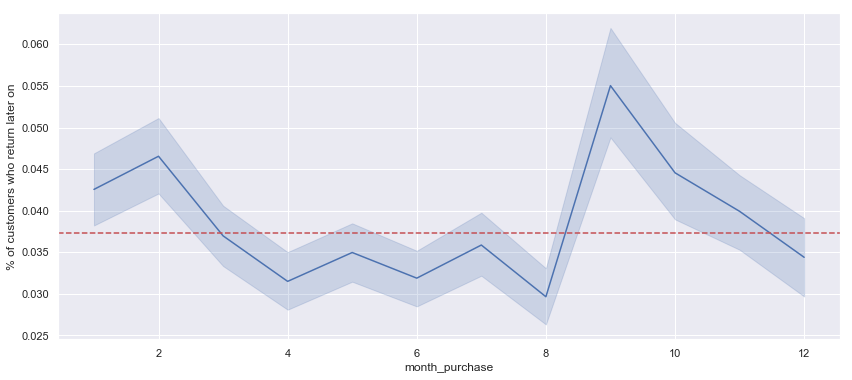

In [19]:
sns.lineplot(orders_filtered.month_purchase, orders_filtered.max_num_orders > 1)
plt.axhline(y = (orders_filtered.max_num_orders > 1).sum() / orders_filtered.shape[0], color = 'r', linestyle='--')
plt.ylabel("% of customers who return later on")

From the above plot, we can see that there is a discernible difference in % of recurring customers for each month. 

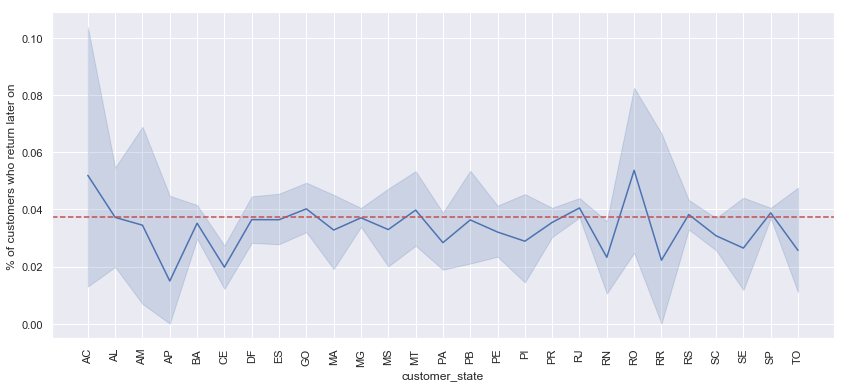

In [20]:
sns.lineplot(orders_filtered.customer_state, orders_filtered.max_num_orders > 1)
plt.axhline(y = (orders_filtered.max_num_orders > 1).sum() / orders_filtered.shape[0], color = 'r', linestyle='--')
plt.ylabel("% of customers who return later on")
_ = plt.xticks(rotation=90)

From the above plot, we can also see that there is a discernible difference in % of recurring customers for each state. 

In [21]:
tmp = pd.DataFrame(orders_filtered.groupby(['customer_state', 'month_purchase'])['max_num_orders'].agg(lambda x: (x > 1).sum() / x.shape[0])).reset_index().pivot(index='customer_state', columns='month_purchase')
tmp.columns = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

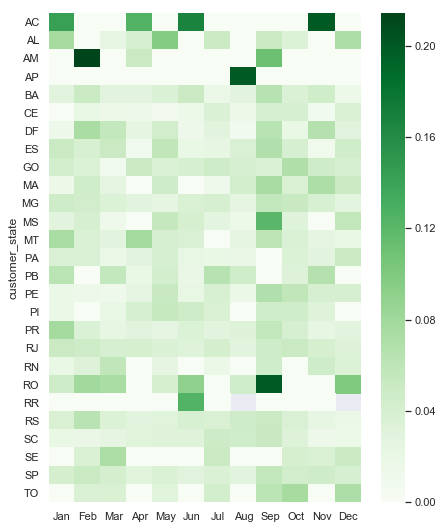

In [22]:
plt.figure(figsize=(7, 9))
sns.heatmap(tmp, cmap='Greens')
_ = plt.yticks(rotation=0)

C:\Users\yenter\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


  1:  0.1689,  0.0267
  2:  0.0338,  0.0426


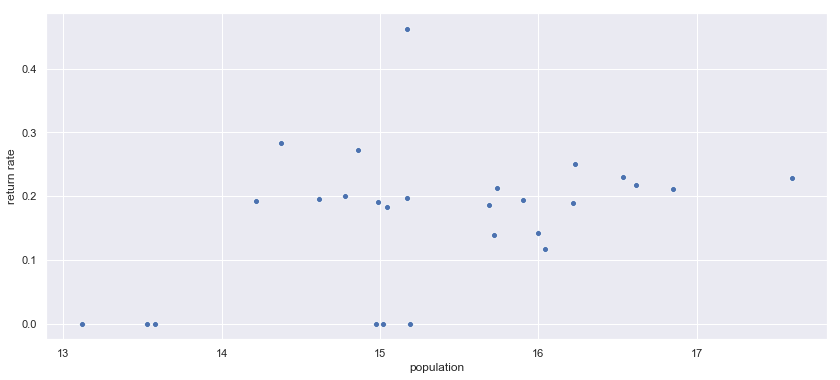

  3:  0.0553,  0.0283
  4:  0.0912,  0.0315
  5:  0.0199,  0.0369


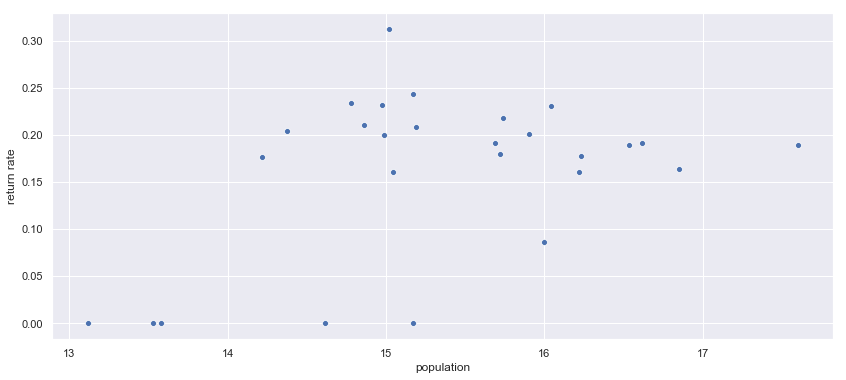

  6:  0.7932, -0.0055
  7:  0.0034,  0.0440


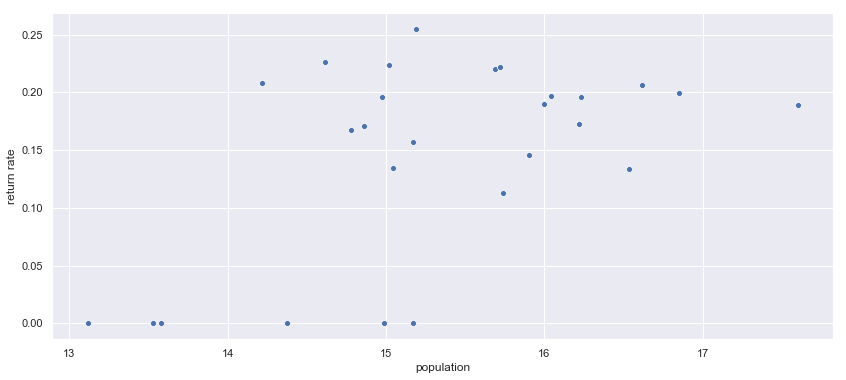

  8:  0.4538,  0.0165
  9:  0.0804,  0.0389
 10:  0.0008,  0.0524


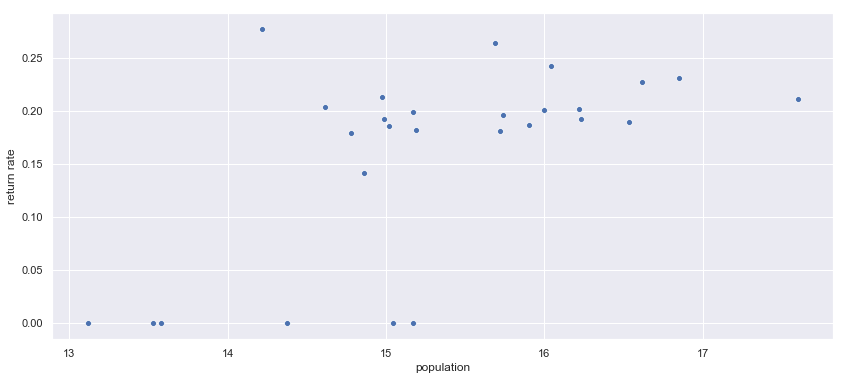

 11:  0.1432,  0.0304
 12:  0.3064,  0.0195


In [135]:
pvals = []
for i in range(1, 13):
    t = tmp[tmp.month_purchase == str(i)]
    model = sm.OLS(t.max_num_orders, sm.add_constant(t[['population']])).fit()
    print("{: 3}: {: .4f}, {: .4f}".format(i, round(model.f_pvalue, 4), round(model.params['population'], 4)))
    pvals.append(model.f_pvalue)
#     display(model.summary())
    if model.f_pvalue < 0.05:
        sns.scatterplot(t.population, t.max_num_orders)
        plt.ylabel('return rate')
        plt.show()

Text(0.5, 0, 'Purchase Month')

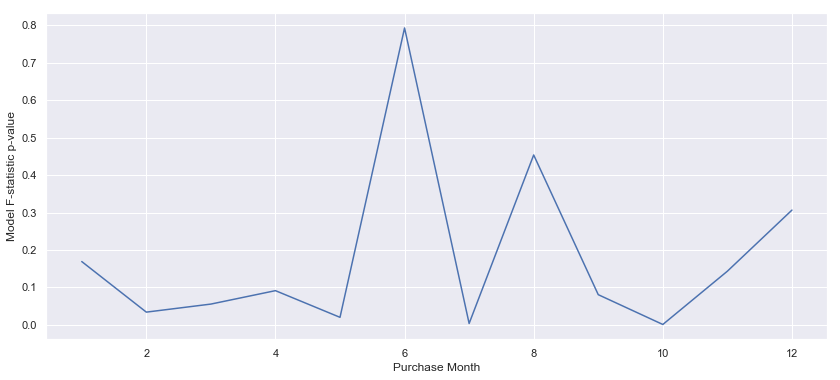

In [136]:
sns.lineplot(range(1, 13), pvals)
plt.ylabel("Model F-statistic p-value")
plt.xlabel("Purchase Month")

In [133]:
cols = ['population']
tmp = orders_filtered.groupby(cols+['month_purchase'])['max_num_orders'].agg(lambda x: (x > 1).sum() / x.shape[0]).reset_index()
tmp['month_purchase'] = tmp['month_purchase'].astype(str)

for col in cols:
    tmp[col] = np.log1p(tmp[col])
tmp.max_num_orders = np.sqrt(tmp.max_num_orders)

sm.OLS(tmp.max_num_orders, sm.add_constant(pd.get_dummies(tmp.drop('max_num_orders', axis=1), drop_first=True))).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         max_num_orders   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     3.660
Date:                Wed, 24 Apr 2019   Prob (F-statistic):           3.72e-05
Time:                        09:57:47   Log-Likelihood:                 308.03
No. Observations:                 322   AIC:                            -590.1
Df Residuals:                     309   BIC:                            -541.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.3090      0.081     -3.792      0.000      -0.469      -0.149
population            0.0305      0.005      5.892      0.000       0.020       0.041
month_purchase_10     0.0004      0.026      0.014      0.989      -0.050       0.051
month_purchase_11    -0.0093      0.026     -0.360      0.719      -0.060       0.042
month_purchase_12    -0.0003      0.026     -0.013      0.990      -0.052       0.051
month_purchase_2      0.0076      0.026      0.294      0.769      -0.043       0.058
month_purchase_3     -0.0045      0.026     -0.172      0.863      -0.055       0.046
month_purchase_4     -0.0253      0.026     -0.980      0.328      -0.076       0.026
month_purchase_5      0.0025      0.026      0.098      0.922      -0.048       0.053
month_purchase_6     -0.0093      0.026     -0.360      0.719      -0.060       0.042
month_purchase_7     -0.0136      0.026     -0.527      0.599      -0.064       0.037
month_purchase_8     -0.0252      0.026     -0.965      0.335      -0.076       0.026
month_purchase_9      0.0396      0.026      1.535      0.126      -0.011       0.090
==============================================================================
Omnibus:                       29.213   Durbin-Watson:                   2.315
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.965
Skew:                           0.568   Prob(JB):                     3.84e-11
Kurtosis:                       4.511   Cond. No.                         245.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
numeric_columns = [x for x in orders_filtered.drop(['customer_zip_code_prefix', 'customer_num_order'], axis=1).columns if (orders_filtered[x].dtype == np.float64 or orders_filtered[x].dtype == np.int64)]

In [223]:
numeric_columns

['gdp',
 'size',
 'population',
 'gdp_per_capita',
 'population_density',
 'num_payments',
 'nunique_payments',
 'percent_voucher',
 'num_installments',
 'time_to_approve',
 'time_to_ship',
 'time_to_reach',
 'days_delivery_diff',
 'month_purchase',
 'max_num_orders',
 'num_items',
 'price_sum',
 'price_mean',
 'freight_value_sum',
 'freight_value_mean',
 'product_id_nunique',
 'seller_id_nunique',
 'num_reviews',
 'avg_review']

In [39]:
sns.set(rc={'figure.figsize':(8, 4)})

In [45]:
log_cols = ['gdp', 'size', 'population', 'gdp_per_capita', 'population_density', 'num_installments', 'time_to_approve', 'time_to_ship', 'time_to_reach', 'price_sum', 'price_mean', 'freight_value_sum', 'freight_value_mean']
cat_cols = ['num_payments', 'nunique_payments', 'num_items', 'product_id_nunique', 'seller_id_nunique', 'num_reviews']

In [91]:
# remove population (high correlation), size, gdp_per_capita, seller_id_nunique, avg_review (high p-value)

# subset = orders_filtered[['max_num_orders', 'gdp', 'time_to_approve', 
#         'time_to_ship', 'time_to_reach', 'days_delivery_diff', 
#         'num_items', 'price_sum', 'freight_value_mean', 'month_purchase', 
#         'num_reviews']]

subset = orders_filtered[numeric_columns]

for col in subset.columns:
    np.ma.fix_invalid(subset[col], copy = False, fill_value=np.ma.masked_invalid(subset[col]).mean())
    if col in log_cols:
        subset[col] = np.log1p(subset[col])
    elif col in cat_cols:
        subset[col] = round(subset[col] > 1)
#     subset[col] = np.log1p(subset[col])
        
# for col in ['freight_value_sum', 'freight_value_mean', 'gdp_per_capita', 'num_items', 'price_sum', 'size', 'time_to_approve']:
#     if col in subset.columns:
#         subset[col] = np.log1p(subset[col])

subset.dropna(inplace=True)
subset['y'] = subset.max_num_orders > 1
subset.drop('max_num_orders', inplace=True, axis=1)

C:\Users\leeye\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\leeye\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\leeye\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log1p
  del sys.path[0]
C:\Users\leeye\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set o

In [99]:
def stepwise_regression(model_type, df, y):
    
    def process(cols):
        X = sm.add_constant(df[cols])
        if model_type == "ols":
            model = sm.OLS(y, X).fit(disp = 0)
        else:
            model = sm.Logit(y, X).fit(disp = 0)
        pred_y = round(model.predict(X))
        return (model, pred_y)
    
    selected_columns = []
    available_columns = df.columns
    best_score = 0
    best_aic = np.inf
    best_pred_y = pd.Series()
    while len(selected_columns) < len(available_columns):
        col_to_add = None
        for col in available_columns:
            if col in selected_columns:
                continue
            # Build a model with each col
            X = sm.add_constant(df[selected_columns + [col]])
            try:
                model, pred_y = process(selected_columns + [col])
            except:
                continue
            if model_type == "ols":
                score = mean_squared_error(y, pred_y)
            else:
                score = recall_score(y, pred_y)
            if score > best_score: # or (score == best_score and model.aic < best_aic):
                best_score = score
                best_aic = model.aic
                col_to_add = col
                best_pred_y = pred_y
            
        if col_to_add is None:
            # Couldn't find anything better
            X = sm.add_constant(df[selected_columns])
            model, pred_y = process(selected_columns)
            return (model, best_score, pred_y)
        else:
            selected_columns.append(col_to_add)
    X = sm.add_constant(df[selected_columns])
    model, pred_y = process(selected_columns)
    return (model, best_score, pred_y)

In [100]:
model, best_score, pred_y = stepwise_regression('', subset.drop(['y', 'month_purchase'], axis=1), subset.y)
print("Recall: {:.3f}%".format(best_score * 100))

Recall: 8.964%


In [102]:
precision_score(subset.y, pred_y)

0.7945544554455446

In [96]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                95365
Model:                          Logit   Df Residuals:                    95363
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                 0.05670
Time:                        17:13:14   Log-Likelihood:                -14400.
converged:                       True   LL-Null:                       -15266.
                                        LLR p-value:                     0.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.3368      0.018   -187.221      0.000      -3.372      -3.302
num_reviews     4.6894      0.124     37.689      0.000       4.446       4.933
===============================================================================
"""

In [141]:
np.exp(4.6894)

108.78788748918576

In [600]:
# ProfileReport(subset.drop('y', axis=1))

In [94]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [138]:
true_y = pd.Series()
pred_y = pd.Series()
month_recalls = []

for month in tqdm_notebook(range(1, 13)):
    X = subset[subset.month_purchase == month].drop(['y', 'month_purchase'], axis=1)
    y = subset[subset.month_purchase == month].y
    
#     pred = round(model.predict(sm.add_constant(X[['num_reviews']])))
#     true_y = true_y.append(y)
#     pred_y = pred_y.append(pred)
#     month_recalls.append(recall_score(y, pred) * 100)
    
    model, best_score, pred_y_found = stepwise_regression('', X, y)
    true_y = true_y.append(y)
    pred_y = pred_y.append(pred_y_found)
    display(Markdown("# Month " + str(month)))
    display(model.summary())
    display(Markdown("Recall: {:.3f}%".format(best_score * 100)))
    month_recalls.append(best_score * 100)

print("Precision: {: 7.3f}%".format(precision_score(true_y, pred_y) * 100))
print("Recall:    {: 7.3f}%".format(recall_score(true_y, pred_y) * 100))

C:\Users\leeye\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


# Month 1

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 7821
Model:                          Logit   Df Residuals:                     7819
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                 0.05591
Time:                        17:23:11   Log-Likelihood:                -1299.9
converged:                       True   LL-Null:                       -1376.9
                                        LLR p-value:                 2.345e-35
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.2032      0.059    -54.749      0.000      -3.318      -3.089
num_reviews     4.7788      0.452     10.566      0.000       3.892       5.665
===============================================================================
"""

Recall: 8.709%

# Month 2

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 8256
Model:                          Logit   Df Residuals:                     8254
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                 0.09096
Time:                        17:23:12   Log-Likelihood:                -1414.5
converged:                       True   LL-Null:                       -1556.1
                                        LLR p-value:                 1.589e-63
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.1703      0.056    -56.419      0.000      -3.280      -3.060
num_reviews     4.6927      0.324     14.505      0.000       4.059       5.327
===============================================================================
"""

Recall: 14.286%

# Month 3

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 9651
Model:                          Logit   Df Residuals:                     9649
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                 0.05403
Time:                        17:23:13   Log-Likelihood:                -1444.8
converged:                       True   LL-Null:                       -1527.4
                                        LLR p-value:                 8.874e-38
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.3493      0.056    -59.438      0.000      -3.460      -3.239
num_reviews     4.5860      0.383     11.980      0.000       3.836       5.336
===============================================================================
"""

Recall: 8.683%

# Month 4

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 8701
Model:                          Logit   Df Residuals:                     8699
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                 0.02532
Time:                        17:23:15   Log-Likelihood:                -1193.0
converged:                       True   LL-Null:                       -1224.0
                                        LLR p-value:                 3.460e-15
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.4589      0.062    -55.441      0.000      -3.581      -3.337
num_reviews     4.7582      0.654      7.272      0.000       3.476       6.041
===============================================================================
"""

Recall: 3.986%

# Month 5

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10184
Model:                          Logit   Df Residuals:                    10182
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                 0.04650
Time:                        17:23:16   Log-Likelihood:                -1465.5
converged:                       True   LL-Null:                       -1537.0
                                        LLR p-value:                 6.095e-33
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.3995      0.056    -60.564      0.000      -3.509      -3.289
num_reviews     4.7117      0.429     10.970      0.000       3.870       5.553
===============================================================================
"""

Recall: 7.345%

# Month 6

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 8998
Model:                          Logit   Df Residuals:                     8996
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                 0.04367
Time:                        17:23:17   Log-Likelihood:                -1218.9
converged:                       True   LL-Null:                       -1274.6
                                        LLR p-value:                 5.028e-26
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.4806      0.062    -56.122      0.000      -3.602      -3.359
num_reviews     4.6845      0.470      9.976      0.000       3.764       5.605
===============================================================================
"""

Recall: 6.944%

# Month 7

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 9453
Model:                          Logit   Df Residuals:                     9451
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                 0.06588
Time:                        17:23:18   Log-Likelihood:                -1395.4
converged:                       True   LL-Null:                       -1493.8
                                        LLR p-value:                 1.036e-44
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.3693      0.057    -58.609      0.000      -3.482      -3.257
num_reviews     4.7556      0.377     12.611      0.000       4.016       5.495
===============================================================================
"""

Recall: 10.315%

# Month 8

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10433
Model:                          Logit   Df Residuals:                    10431
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                 0.06981
Time:                        17:23:20   Log-Likelihood:                -1301.2
converged:                       True   LL-Null:                       -1398.8
                                        LLR p-value:                 2.194e-44
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.5907      0.061    -59.166      0.000      -3.710      -3.472
num_reviews     5.2646      0.449     11.725      0.000       4.385       6.145
===============================================================================
"""

Recall: 10.289%

# Month 9

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4166
Model:                          Logit   Df Residuals:                     4164
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                 0.02668
Time:                        17:23:21   Log-Likelihood:                -863.25
converged:                       True   LL-Null:                       -886.91
                                        LLR p-value:                 5.990e-12
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.9006      0.070    -41.504      0.000      -3.038      -2.764
num_reviews     3.2683      0.439      7.441      0.000       2.407       4.129
===============================================================================
"""

Recall: 5.677%

# Month 10

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4821
Model:                          Logit   Df Residuals:                     4819
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                 0.06784
Time:                        17:23:22   Log-Likelihood:                -819.19
converged:                       True   LL-Null:                       -878.80
                                        LLR p-value:                 9.332e-28
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.1668      0.073    -43.208      0.000      -3.310      -3.023
num_reviews     5.5182      0.744      7.421      0.000       4.061       6.976
===============================================================================
"""

Recall: 9.767%

# Month 11

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 7363
Model:                          Logit   Df Residuals:                     7361
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                 0.06539
Time:                        17:23:24   Log-Likelihood:                -1154.2
converged:                       True   LL-Null:                       -1234.9
                                        LLR p-value:                 5.327e-37
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.2936      0.063    -52.348      0.000      -3.417      -3.170
num_reviews     4.3614      0.355     12.281      0.000       3.665       5.057
===============================================================================
"""

Recall: 10.884%

# Month 12

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 5518
Model:                          Logit   Df Residuals:                     5516
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                 0.05214
Time:                        17:23:25   Log-Likelihood:                -783.65
converged:                       True   LL-Null:                       -826.75
                                        LLR p-value:                 1.616e-20
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.4154      0.077    -44.457      0.000      -3.566      -3.265
num_reviews     5.0248      0.637      7.887      0.000       3.776       6.274
===============================================================================
"""

Recall: 7.895%


Precision:  79.455%
Recall:      8.964%


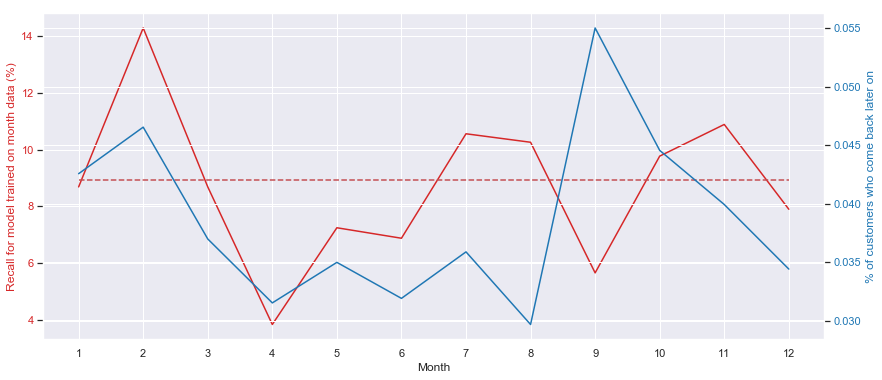

In [258]:
fig, ax1 = plt.subplots()
p = sns.lineplot(range(1, 13), month_recalls, ax=ax1, color='tab:red')
ax1.plot(range(1, 13), [recall_score(true_y, pred_y) * 100] * 12, 'r--')
ax1.set_xlabel("Month")
ax1.set_ylabel("Recall for model trained on month data (%)", color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
_ = plt.xticks(range(1, 13))
ax2 = ax1.twinx()
sns.lineplot(orders_filtered.month_purchase, orders_filtered.max_num_orders > 1, err_style=None, ax=ax2, color='tab:blue')
ax2.set_ylabel("% of customers who come back later on", color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Clustering Customers

In [99]:
order_items_joined = orders.join(order_items.set_index('order_id'), on='order_id')[['customer_unique_id', 'product_category', 'price', 'freight_value']]
order_items_joined = pd.DataFrame(order_items_joined.groupby('customer_unique_id').progress_apply(lambda x: [list(y) for y in x.drop('customer_unique_id', axis=1).to_records(index=False)]))
order_items_joined.columns = ['purchases']

In [331]:
customers_joined = customers.set_index('customer_unique_id').join(order_items_joined)

In [332]:
customers_joined

,customer_id,customer_zip_code_prefix,customer_city,customer_state,gdp,size,population,gdp_per_capita,purchases
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,fadbb3709178fc513abc1b2670aa1ad2,7787,cajamar,SP,628064882,248209,44035304,14.262758,"[[cama_mesa_banho, 129.9, 12.0]]"
0000b849f77a49e4a4ce2b2a4ca5be3f,4cb282e167ae9234755102258dd52ee8,6053,osasco,SP,628064882,248209,44035304,14.262758,"[[beleza_saude, 18.9, 8.29]]"
0000f46a3911fa3c0805444483337064,9b3932a6253894a02c1df9d19004239f,88115,sao jose,SC,17328527,95346,6727148,2.575910,"[[papelaria, 69.0, 17.22]]"
0000f6ccb0745a6a4b88665a16c9f078,914991f0c02ef0843c0e7010c819d642,66812,belem,PA,28706165,1247689,8073924,3.555417,"[[telefonia, 25.99, 17.63]]"
0004aac84e0df4da2b147fca70cf8255,47227568b10f5f58a524a75507e6992c,18040,sorocaba,SP,628064882,248209,44035304,14.262758,"[[telefonia, 180.0, 16.89]]"
0004bd2a26a76fe21f786e4fbd80607f,4a913a170c26e3c8052ed0202849b5a8,5036,sao paulo,SP,628064882,248209,44035304,14.262758,"[[ferramentas_jardim, 154.0, 12.98]]"
00050ab1314c0e55a6ca13cf7181fecf,d2509c13692836fc0449e88cf9eb4858,13084,campinas,SP,628064882,248209,44035304,14.262758,"[[telefonia, 27.99, 7.39]]"
00053a61a98854899e70ed204dd4bafe,a81ebb9b32f102298c0c89635b4b3154,80410,curitiba,PR,78892229,199315,11081692,7.119150,"[[esporte_lazer, 191.0, 18.59], [esporte_lazer..."
0005e1862207bf6ccc02e4228effd9a0,3b37fb626fdf46cd99d37ec62afa88ff,25966,teresopolis,RJ,299849795,43696,16461173,18.215579,"[[fashion_bolsas_e_acessorios, 135.0, 15.12]]"


In [431]:
from sklearn.cluster import DBSCAN
import scipy.sparse
from progressbar import ProgressBar

In [421]:
def get_categories(purchases):
    result = set()
    for purchase in purchases:
        result.add(purchase[0])
    return result

In [633]:
num_customers = customers.shape[0]
num_customers = round(num_customers * 0.5) # if we get memory error from trying to build the full array

In [634]:
categories = {}

for i in tqdm_notebook(range(num_customers)):
    categories[i] = get_categories(customers_joined.iloc[i].purchases)

In [635]:
distances = np.zeros([num_customers, num_customers], np.float16)
bar = ProgressBar(max_value=(num_customers-1) * (num_customers) / 2)
count = 0
for i in range(num_customers-1):
    distances[i][i] = 1
    for j in range(i+1, num_customers):
        # calc distance
        # using jaccard index
        intersect = len(categories[i] & categories[j])
        if (intersect > 0):
            distance = intersect / len(categories[i] | categories[j])
            distances[i][j] = distance
            distances[j][i] = distance
    count += (num_customers - i - 2)
    bar.update(count)
bar.finish()

100% (1236014340.0 of 1236014340.0) |####| Elapsed Time: 0:06:48 Time:  0:06:48


In [636]:
distances = 1 - distances

In [640]:
clustering = DBSCAN(metric='precomputed').fit(distances)

C:\Users\yenter\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\yenter\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\yenter\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\yenter\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


MemoryError: 

In [ ]:
pd.Series(clustering.labels_).value_counts()

# Random. 

Analysing sellers and products

In [55]:
product_reviews = order_items.set_index('order_id').join(reviews.set_index('order_id'))[['product_id', 'seller_id', 'review_creation_date', 'review_score']].reset_index(drop=True)

In [59]:
product_reviews.head()

,product_id,seller_id,review_creation_date,review_score
0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-21,5
1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-13,4
2,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-23,5
3,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15,4
4,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-03-02,5


In [57]:
product_reviews.groupby('product_id').size().sort_values(ascending=False).head()

product_id
aca2eb7d00ea1a7b8ebd4e68314663af    527
99a4788cb24856965c36a24e339b6058    491
422879e10f46682990de24d770e7f83d    487
389d119b48cf3043d311335e499d9c6b    392
368c6c730842d78016ad823897a372db    391
dtype: int64

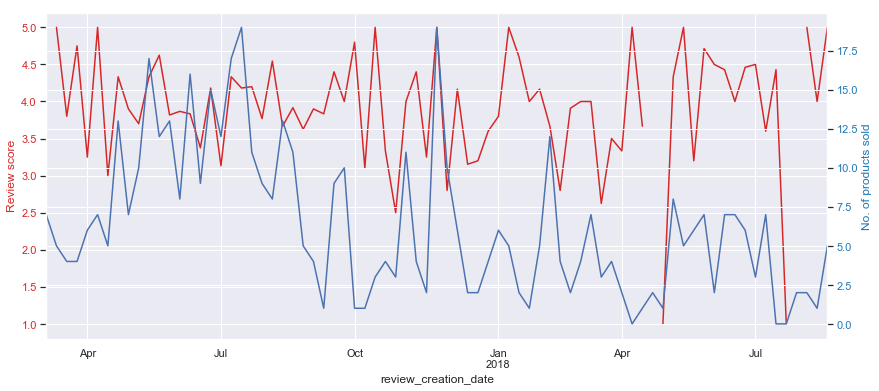

In [97]:
product_id = '99a4788cb24856965c36a24e339b6058'
interval = 'W'
fig, ax1 = plt.subplots()
product_reviews[product_reviews.product_id == product_id].sort_values('review_creation_date').set_index('review_creation_date')['review_score'].resample(interval).mean().plot(color='tab:red')
ax1.set_ylabel("Review score", color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax2 = ax1.twinx()
order_items[order_items.product_id == product_id].join(orders.set_index('order_id')[['order_purchase_timestamp']], on='order_id')[['order_purchase_timestamp']].set_index('order_purchase_timestamp').resample(interval).size().plot()
ax2.set_ylabel("No. of products sold", color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Others

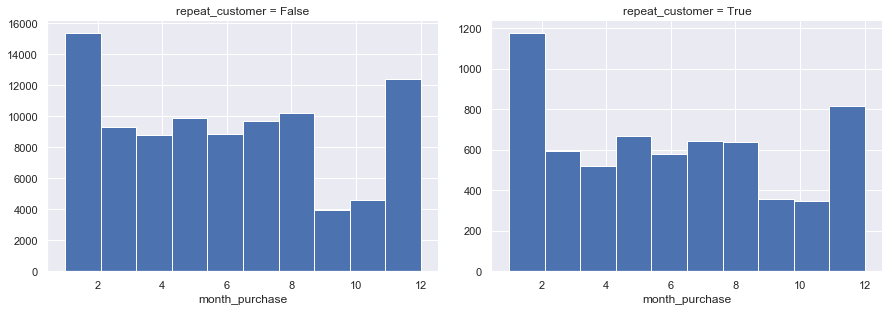

In [170]:
g = sns.FacetGrid(orders, col='repeat_customer', sharey = False, height=4.5, aspect=1.4)
g = g.map(plt.hist, "month_purchase")

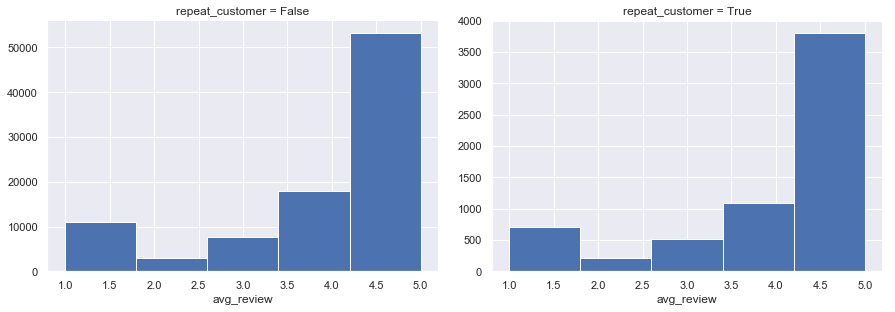

In [180]:
g = sns.FacetGrid(orders, col='repeat_customer', sharey = False, height=4.5, aspect=1.4)
g = g.map(plt.hist, "avg_review", bins=5)

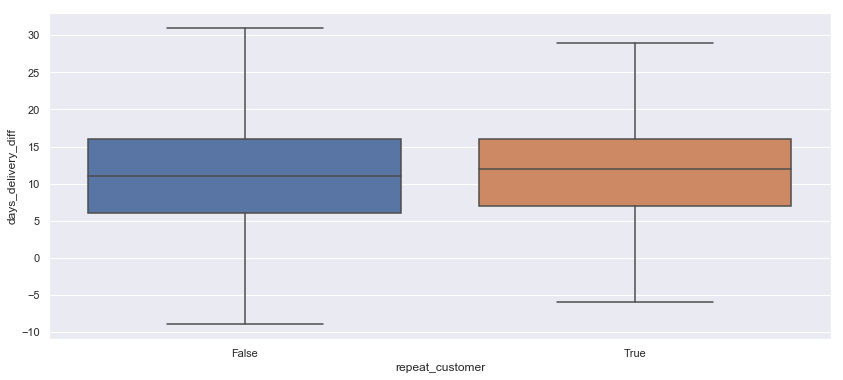

In [197]:
sns.boxplot(orders.repeat_customer, orders.days_delivery_diff, showfliers=False)

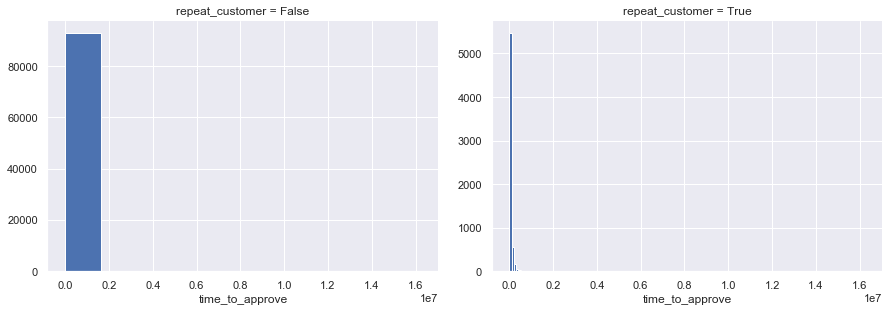

In [201]:
g = sns.FacetGrid(orders, col='repeat_customer', sharey = False, height=4.5, aspect=1.4)
g = g.map(plt.hist, "time_to_approve")

In [222]:
orders['time_to_approve_bins'] = pd.qcut(orders.time_to_approve, 10)

In [246]:
results = []
for category in orders['time_to_approve_bins'].cat.categories:
    sub = orders[orders.time_to_approve_bins == category]
    results.append([category, "{0:.3f}".format(sub.repeat_customer.sum() / sub.shape[0] * 100)])
print(tabulate(results, headers=('time_to_approve', '% repeat')))

time_to_approve           % repeat
----------------------  ----------
(-0.001, 605.0]              6.846
(605.0, 721.0]               6.821
(721.0, 832.0]               6.767
(832.0, 978.0]               6.12
(978.0, 1236.0]              6.471
(1236.0, 2214.0]             5.623
(2214.0, 21798.0]            6.487
(21798.0, 76783.0]           6.104
(76783.0, 124775.0]          5.852
(124775.0, 16233050.0]       6.144


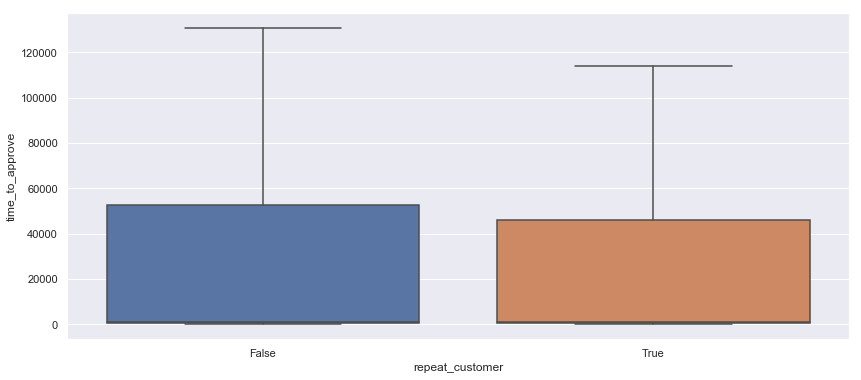

In [200]:
sns.boxplot(orders.repeat_customer, orders.time_to_approve, showfliers=False)

In [142]:
import json

In [187]:
with open("labels.json") as f:
    labels = json.load(f)

labels = pd.DataFrame.from_dict(labels, orient='index')
labels.columns = ['cluster']
customers['clusters'] = list(labels.cluster)

In [179]:
(customers.clusters.value_counts().sort_values(ascending=False) > 1000).sum()

22

In [188]:
customers_tmp = customers.join(max_num_orders, on='customer_unique_id')[['max_num_orders', 'clusters']]

In [ ]:
sns.scatterplot(tmp.return_rate)

Text(0.5, 0, 'Return rate (%)')

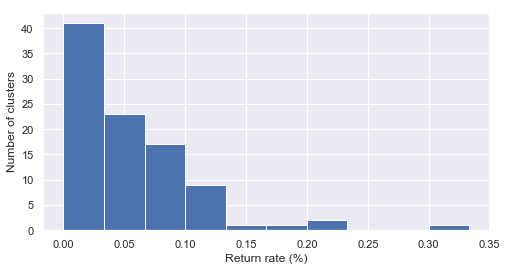

In [196]:
tmp.return_rate.hist()
plt.ylabel('Number of clusters')
plt.xlabel('Return rate (%)')

In [195]:
tmp = customers_tmp.groupby('clusters').agg({'max_num_orders': ['size', 'mean', lambda x: (x > 1).sum() / x.shape[0]]})
tmp.columns = ['size', 'avg_max_orders', 'return_rate']
tmp.sort_values('return_rate', ascending=False)

,size,avg_max_orders,return_rate
clusters,,,
14,6,1.500000,0.333333
72,9,1.222222,0.222222
38,5,1.200000,0.200000
62,17,1.176471,0.176471
85,7,1.142857,0.142857
71,8,1.125000,0.125000
61,8,1.125000,0.125000
63,8,1.125000,0.125000
30,17,1.117647,0.117647
